In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


from collections import Counter
from scipy.stats import mode

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [4]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
full_model_path =  r'C:\Users\k54739\Bibi_new_thesis\saved_model\resize_simclr_modelepoch250.pth' 
simclr_model = torch.load(full_model_path)
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_5400\3495648145.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [6]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label, img_path

def load_data(root_dir):

    classes = ['cond7_all', 'sd','ex'] #full dataset
    #classes = ['cond7_curated', 'sd','ex'] # curated full dataset



    #classes = ['cond7_40', 'sd_40','ex'] # 40 subset
    #classes = ['curated_cond7_40', 'sd_40','ex'] # curated 40 subset





    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
image_dir =  r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

#image_dir =  r"C:\Users\k54739\Bibi_new_thesis\thesis\classification\cluster_40"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'cond7_all': 472, 'sd': 125, 'ex': 40}


In [7]:
for anchor,label, path in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    print(path)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0])
['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\the

In [8]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels, paths = [], [], []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        print(f"Batch labels shape: {batch_paths}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
        paths.extend(batch_paths) 

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")
    print(f"Number of paths after concatenation: {len(paths)}")

    return feats, labels, paths

In [9]:
# Extract features for train and test datasets
feats, labels, paths = prepare_data_features(simclr_model, loader_labeled)

  2%|▎         | 1/40 [00:00<00:31,  1.25it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\ds1b_g5_E3.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_C8.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61

  5%|▌         | 2/40 [00:01<00:28,  1.35it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7

  8%|▊         | 3/40 [00:02<00:27,  1.36it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 10%|█         | 4/40 [00:02<00:26,  1.38it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g8_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\

 12%|█▎        | 5/40 [00:03<00:25,  1.40it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\clas

 15%|█▌        | 6/40 [00:04<00:24,  1.40it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g9_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\

 18%|█▊        | 7/40 [00:05<00:23,  1.43it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classifica

 20%|██        | 8/40 [00:05<00:22,  1.43it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7

 22%|██▎       | 9/40 [00:06<00:22,  1.37it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\clas

 25%|██▌       | 10/40 [00:07<00:22,  1.33it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\ds42_g5_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\ds1b_g5_E2.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond

 28%|██▊       | 11/40 [00:08<00:22,  1.29it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 30%|███       | 12/40 [00:08<00:22,  1.26it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g3_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g6_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond

 32%|███▎      | 13/40 [00:09<00:21,  1.24it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classific

 35%|███▌      | 14/40 [00:10<00:21,  1.23it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\

 38%|███▊      | 15/40 [00:11<00:21,  1.16it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 40%|████      | 16/40 [00:12<00:20,  1.19it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g8_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classific

 42%|████▎     | 17/40 [00:13<00:18,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\

 45%|████▌     | 18/40 [00:13<00:17,  1.24it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis

 48%|████▊     | 19/40 [00:14<00:16,  1.25it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classifica

 50%|█████     | 20/40 [00:15<00:15,  1.26it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\ds1b_g5_E5.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classific

 52%|█████▎    | 21/40 [00:16<00:14,  1.27it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\clas

 55%|█████▌    | 22/40 [00:17<00:14,  1.26it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\clas

 57%|█████▊    | 23/40 [00:17<00:13,  1.25it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_c10.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_C11.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_

 60%|██████    | 24/40 [00:18<00:13,  1.21it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\

 62%|██████▎   | 25/40 [00:19<00:12,  1.21it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_C7.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\

 65%|██████▌   | 26/40 [00:20<00:11,  1.23it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\ds41_g5_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\ds62_g2_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification

 68%|██████▊   | 27/40 [00:21<00:10,  1.24it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_C9.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g8_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\con

 70%|███████   | 28/40 [00:22<00:09,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7

 72%|███████▎  | 29/40 [00:22<00:09,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classifica

 75%|███████▌  | 30/40 [00:23<00:08,  1.21it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classifica

 78%|███████▊  | 31/40 [00:24<00:07,  1.23it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\

 80%|████████  | 32/40 [00:25<00:06,  1.23it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\ds42_g5_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 82%|████████▎ | 33/40 [00:26<00:05,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g8_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\

 85%|████████▌ | 34/40 [00:26<00:04,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g6_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\

 88%|████████▊ | 35/40 [00:27<00:04,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g3_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classific

 90%|█████████ | 36/40 [00:28<00:03,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\clas

 92%|█████████▎| 37/40 [00:29<00:02,  1.22it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g6_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7

 95%|█████████▌| 38/40 [00:30<00:01,  1.23it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g9_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\ds42_g5_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\

 98%|█████████▊| 39/40 [00:31<00:00,  1.25it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.09_Day10_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.10_Day10_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.14_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\cl

100%|██████████| 40/40 [00:31<00:00,  1.26it/s]

Batch features shape: torch.Size([13, 512])
Batch labels shape: torch.Size([13])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd\\sd_RBT_01.04_Day10_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\clas

In [10]:
# Convert features and labels to NumPy arrays
feats_np = feats.numpy()
labels_np = labels.numpy()

# Ensure that paths is a list of the correct length
assert len(paths) == feats_np.shape[0], "Mismatch between number of features and paths"

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (637, 512)
Shape of labels: (637,)


From scratch

In [11]:
import numpy as np
from scipy.stats import mode
from collections import Counter

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids
def find_closest_centroids(X, centroids):
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        idx[i] = np.argmin(distances)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis=0) if len(points) > 0 else centroids[k]
    return centroids

# Function to run K-Means algorithm
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])

    for i in range(max_iters):
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)
        
    return centroids, idx

# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)
    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        most_common_label = mode(true_labels[mask], axis=None).mode
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]
        reordered_labels[mask] = most_common_label
    return reordered_labels

# Main loop to run K-Means 100 times and track the best accuracy
K = 3  # Number of clusters
max_iters = 200  # Maximum iterations
num_trials = 150  # Number of trials
max_accuracy = 0  # To store the maximum accuracy achieved

for trial in range(num_trials):
    print(f"Trial {trial + 1}/{num_trials}")
    
    # Initialize centroids
    initial_centroids = kMeans_init_centroids(feats_np, K)
    
    # Run K-Means
    centroids, idx = run_kMeans(feats_np, initial_centroids, max_iters)
    
    # Reorder labels and calculate accuracy
    reordered_idx = reorder_labels(labels_np, idx)
    accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
    
    print(f"Accuracy for trial {trial + 1}: {accuracy:.2f}%")
    
    # Update maximum accuracy if the current one is better
    if accuracy > max_accuracy:
        max_accuracy = accuracy

print(f"Maximum accuracy achieved over {num_trials} trials: {max_accuracy:.2f}%")


Trial 1/150
Accuracy for trial 1: 74.10%
Trial 2/150
Accuracy for trial 2: 74.10%
Trial 3/150
Accuracy for trial 3: 90.11%
Trial 4/150
Accuracy for trial 4: 74.10%
Trial 5/150
Accuracy for trial 5: 74.10%
Trial 6/150
Accuracy for trial 6: 74.10%
Trial 7/150
Accuracy for trial 7: 77.71%
Trial 8/150
Accuracy for trial 8: 88.07%
Trial 9/150
Accuracy for trial 9: 87.44%
Trial 10/150
Accuracy for trial 10: 74.10%
Trial 11/150
Accuracy for trial 11: 74.10%
Trial 12/150
Accuracy for trial 12: 74.10%
Trial 13/150
Accuracy for trial 13: 74.10%
Trial 14/150
Accuracy for trial 14: 74.10%
Trial 15/150
Accuracy for trial 15: 74.10%
Trial 16/150
Accuracy for trial 16: 74.10%
Trial 17/150
Accuracy for trial 17: 74.10%
Trial 18/150
Accuracy for trial 18: 74.10%
Trial 19/150
Accuracy for trial 19: 74.10%
Trial 20/150
Accuracy for trial 20: 74.10%
Trial 21/150
Accuracy for trial 21: 74.10%
Trial 22/150
Accuracy for trial 22: 74.10%
Trial 23/150
Accuracy for trial 23: 74.10%
Trial 24/150
Accuracy for tri

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [13]:
# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


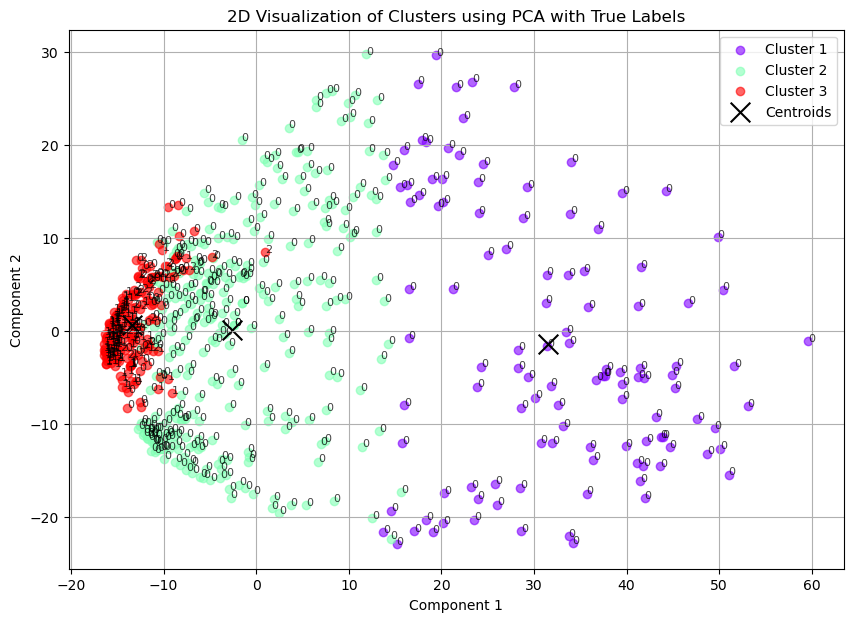

In [14]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)


In [ ]:
# violet probaböly sd whnen i counted 113 actual 125